<a href="https://colab.research.google.com/github/vienskaz/CTSegmentationCNN/blob/main/CTSegmentationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from PIL import Image
import random
import math
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
data_path="/content/drive/MyDrive/Arkusze/Patients_CT"

patients=[]
for i in range(49,131):
  if i <100:
    formated='0'+str(i)
    patients.append(formated)
  else:
    formated=str(i)
    patients.append(formated)


image_data=[]
masks=[]
for patient in patients:
  patient_path=os.path.join(data_path,patient,'brain')
  print(f'{patient}/130')

  for image_file in os.listdir(patient_path):
    hge="HGE"
    image_path=os.path.join(patient_path,image_file)
    if hge in image_path:
      mask=Image.open(image_path).convert("L")
      mask=np.array(mask)
      masks.append(mask)
      imagename = os.path.basename(image_path)
      parts = imagename.split("_")
      number = parts[-3]
      image_data_file=Image.open(os.path.join(patient_path,str(number)+'.jpg')).convert("L")
      image_data_file=np.array(image_data_file)
      image_data.append(image_data_file)

049/130
050/130
051/130
052/130
053/130
054/130
055/130
056/130
057/130
058/130
059/130
060/130
061/130
062/130
063/130
064/130
065/130
066/130
067/130
068/130
069/130
070/130
071/130
072/130
073/130
074/130
075/130
076/130
077/130
078/130
079/130
080/130
081/130
082/130
083/130
084/130
085/130
086/130
087/130
088/130
089/130
090/130
091/130
092/130
093/130
094/130
095/130
096/130
097/130
098/130
099/130
100/130
101/130
102/130
103/130
104/130
105/130
106/130
107/130
108/130
109/130
110/130
111/130
112/130
113/130
114/130
115/130
116/130
117/130
118/130
119/130
120/130
121/130
122/130
123/130
124/130
125/130
126/130
127/130
128/130
129/130
130/130


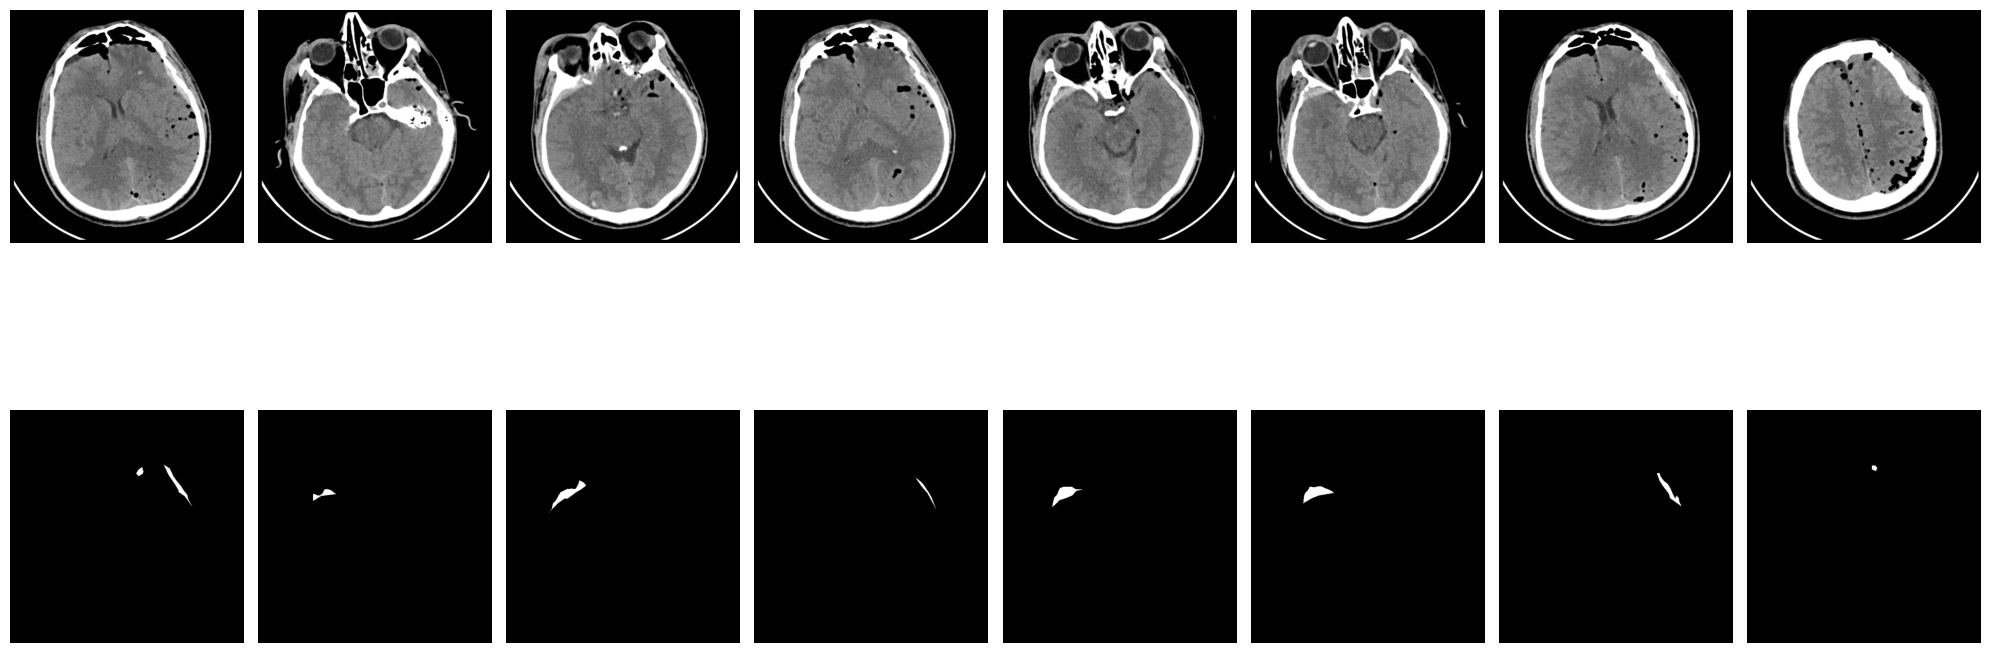

In [3]:
plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')

for i in range(8):
    plt.subplot(2, 8, i + 9)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
split_ratio=(0.2,0.8)

image_data = np.array(image_data)
masks = np.array(masks)


train_images, test_images, train_masks, test_masks = train_test_split(image_data, masks, test_size=split_ratio[0], random_state=42)

In [5]:
def normalize(input_images, input_masks,size=256):

  images=[]
  masks=[]
  for image in input_images:
    image=cv2.resize(image,(size,size))
    image=image/255.0
    images.append(image)

  for mask in input_masks:
    mask=cv2.resize(mask,(size,size))
    mask=mask/255.0
    masks.append(mask)

  input_masks -= 1

  return np.asarray(images),np.asarray(masks)




In [6]:
train_images,train_masks=normalize(train_images,train_masks)
test_images,test_masks=normalize(test_images,test_masks)

In [7]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (256, 256, 1)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
batch_size=16
train_steps_per_epoch = len(train_images) // batch_size
test_steps_per_epoch = len(test_images) // batch_size


history = model.fit(
    train_images, train_masks,  # Provide both input images and corresponding segmentation masks
    epochs=100,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=(test_images, test_masks),  # Provide both test images and corresponding masks
    validation_steps=test_steps_per_epoch
)



Epoch 1/100
15/15 [==============================] - 41s 3s/step - loss: 6.7296 - accuracy: 0.7088 - val_loss: 9.5281 - val_accuracy: 0.3043
Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 6.7259 - accuracy: 0.7125 - val_loss: 19.3344 - val_accuracy: 0.5272
Epoch 3/100
15/15 [==============================] - 16s 1s/step - loss: 6.4502 - accuracy: 0.6927 - val_loss: 17.4840 - val_accuracy: 0.8093
Epoch 4/100
15/15 [==============================] - 15s 1s/step - loss: 6.3125 - accuracy: 0.7027 - val_loss: 20.2311 - val_accuracy: 0.8707
Epoch 5/100
15/15 [==============================] - 16s 1s/step - loss: 6.4301 - accuracy: 0.7041 - val_loss: 24.2822 - val_accuracy: 0.4961
Epoch 6/100
15/15 [==============================] - 16s 1s/step - loss: 6.4835 - accuracy: 0.7131 - val_loss: 23.0854 - val_accuracy: 0.8523
Epoch 7/100
15/15 [==============================] - 15s 1s/step - loss: 6.3313 - accuracy: 0.7207 - val_loss: 25.8321 - val_accuracy: 0.8302
Epoch 8

In [18]:
predicted_masks=model.predict(test_images)

2/2 [==============================] - 1s 553ms/step


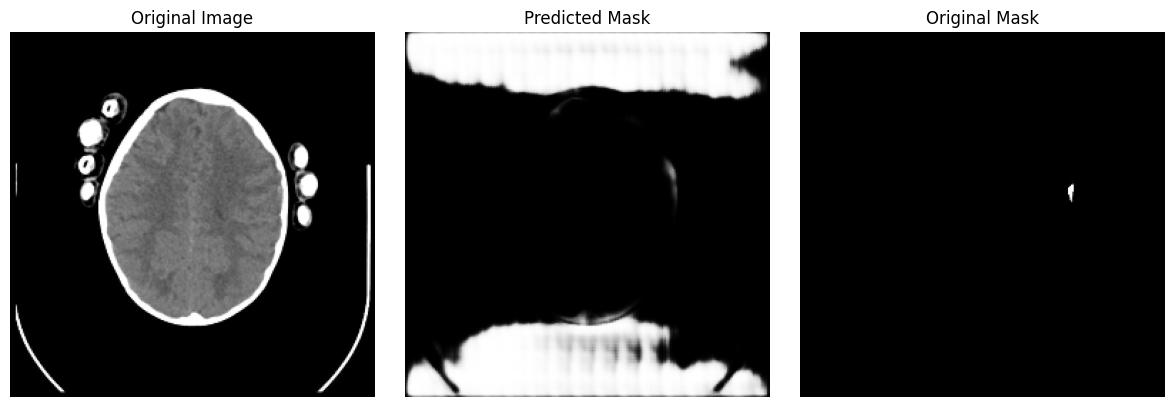

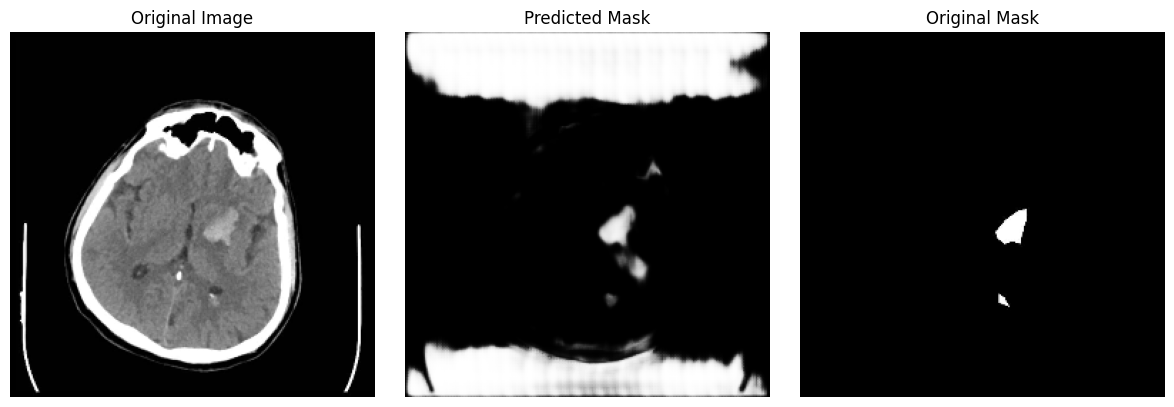

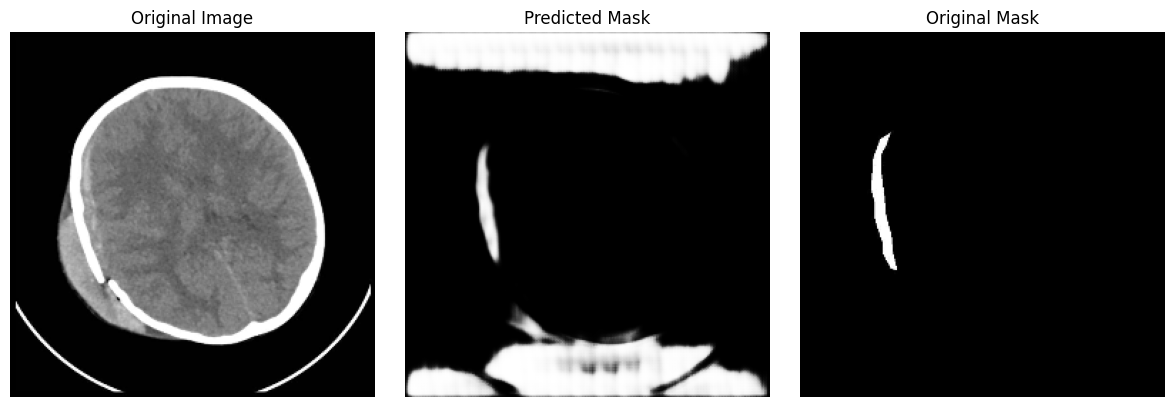

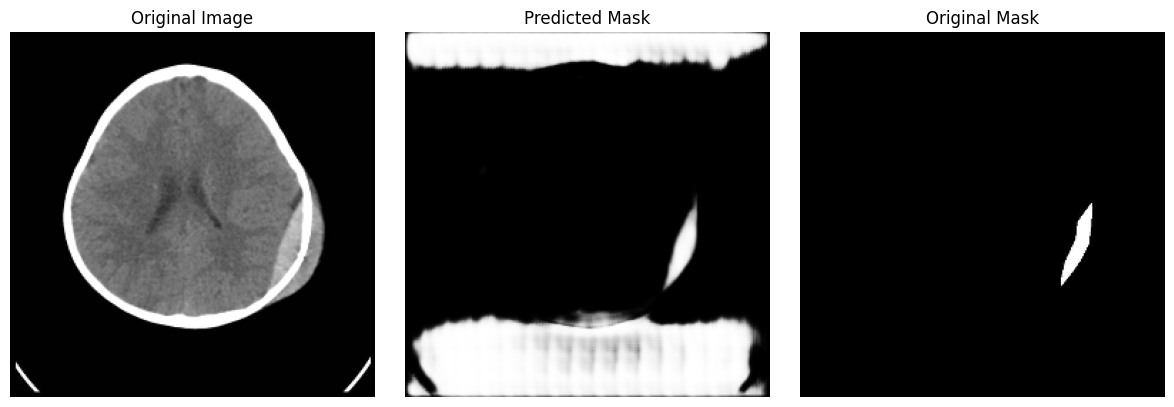

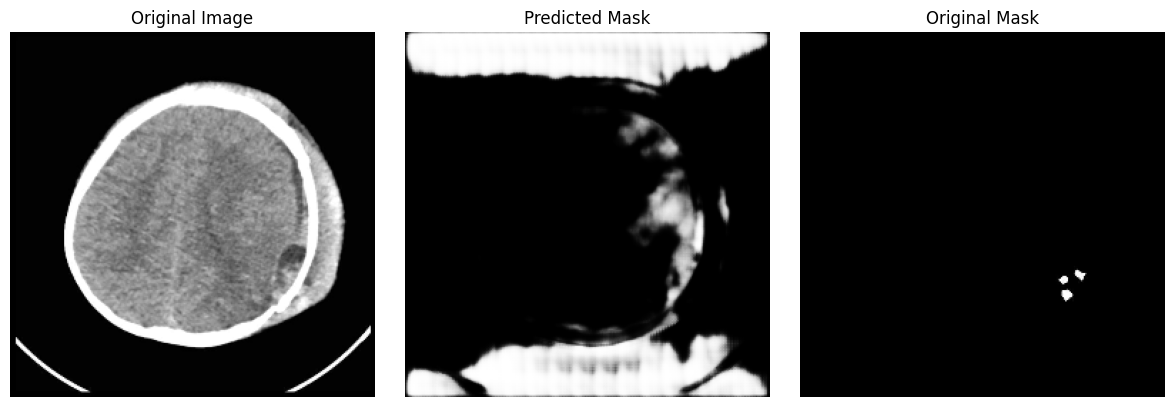

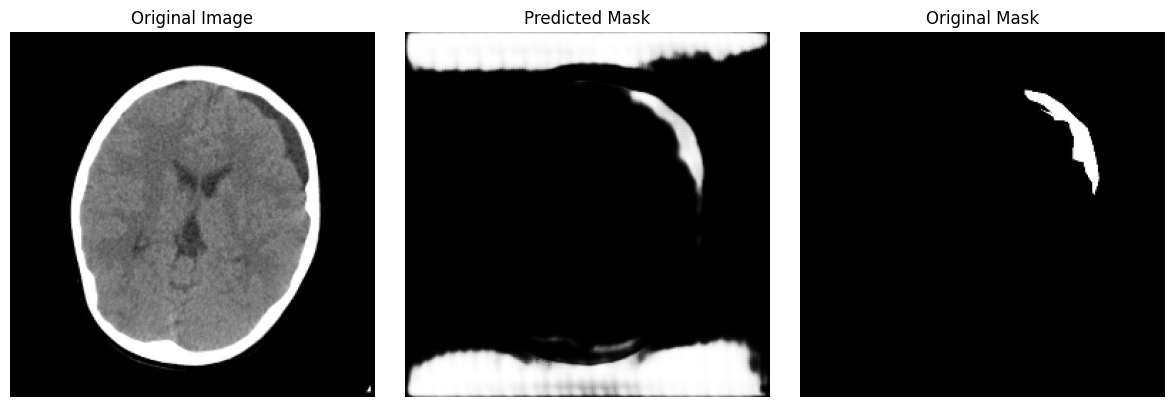

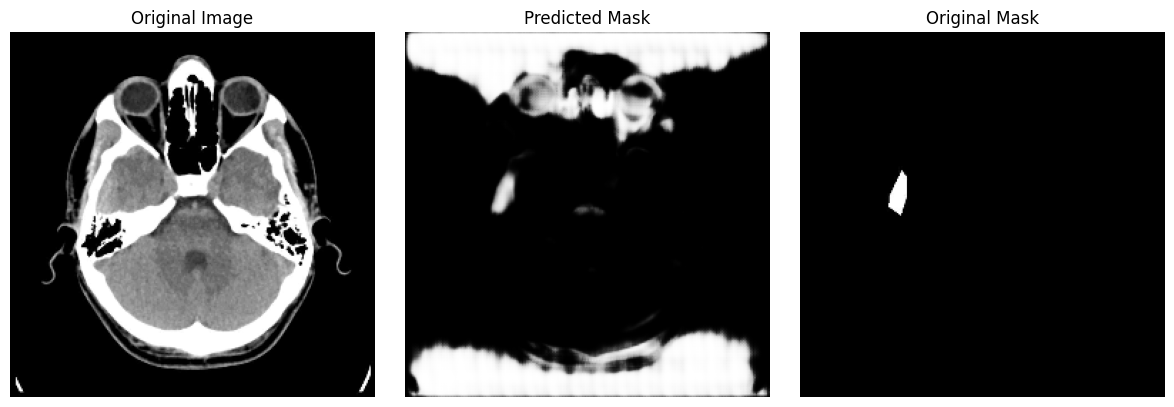

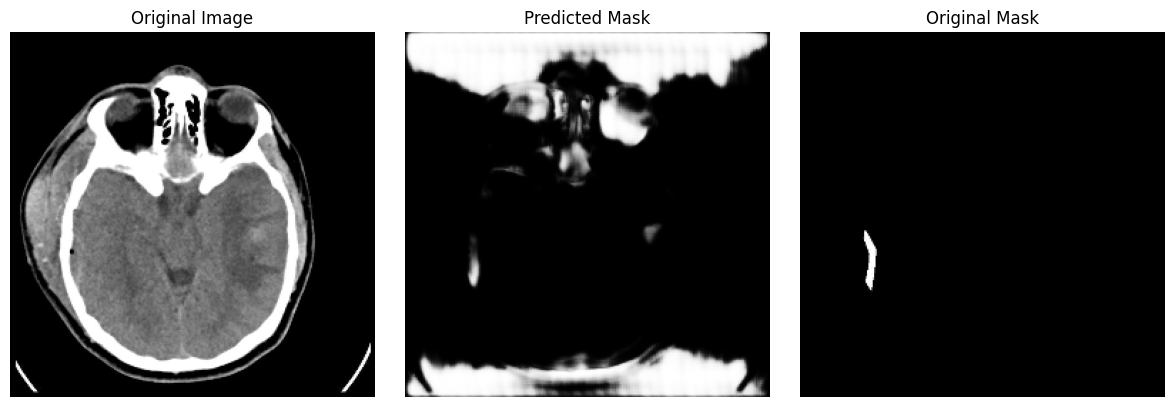

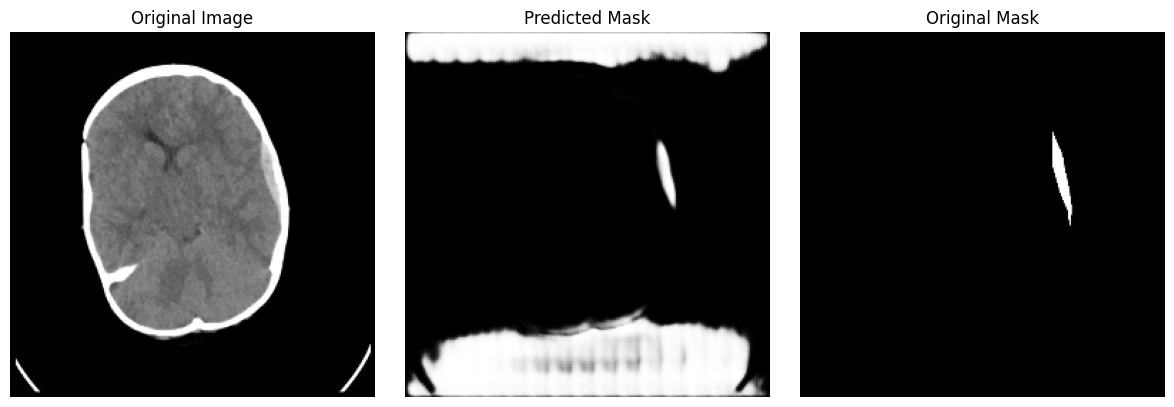

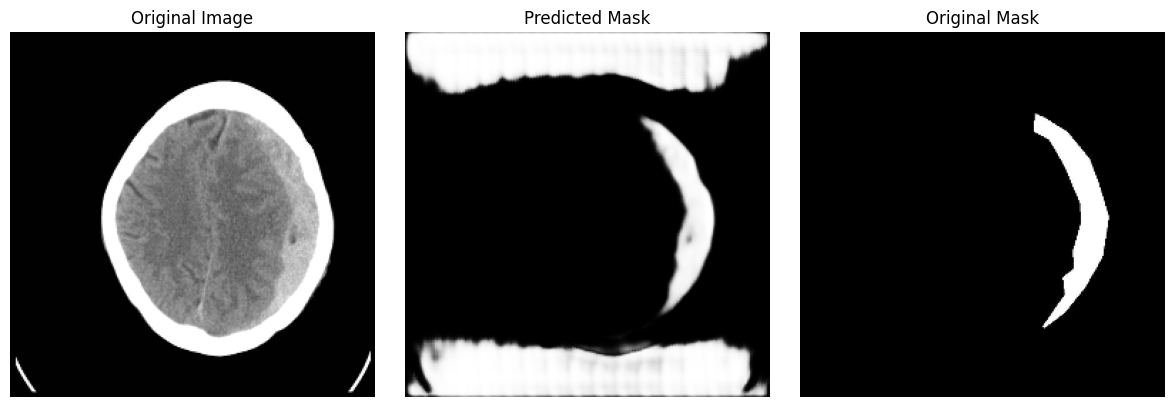

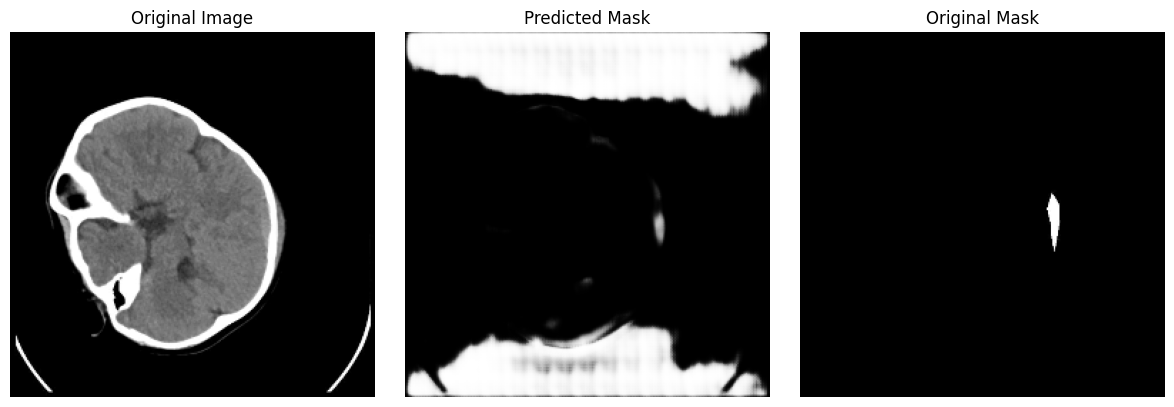

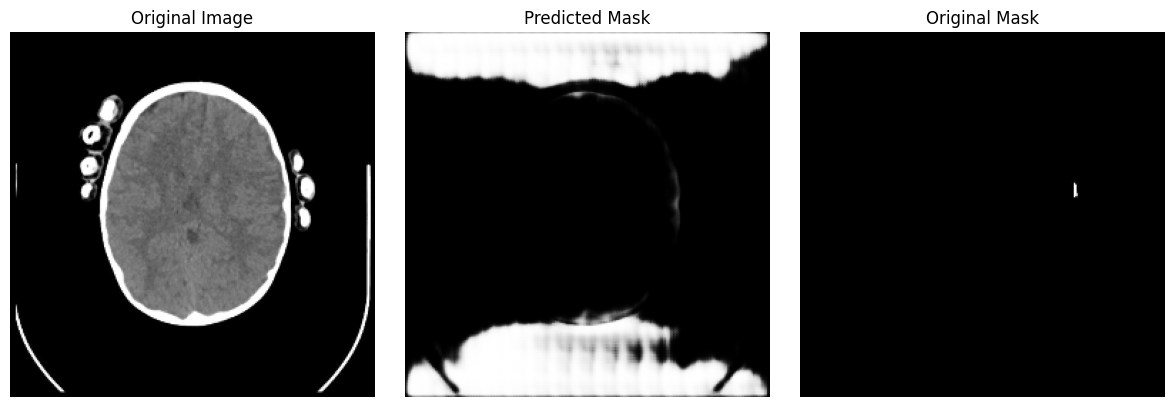

Exception ignored in: <function _xla_gc_callback at 0x7a8ec6311e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


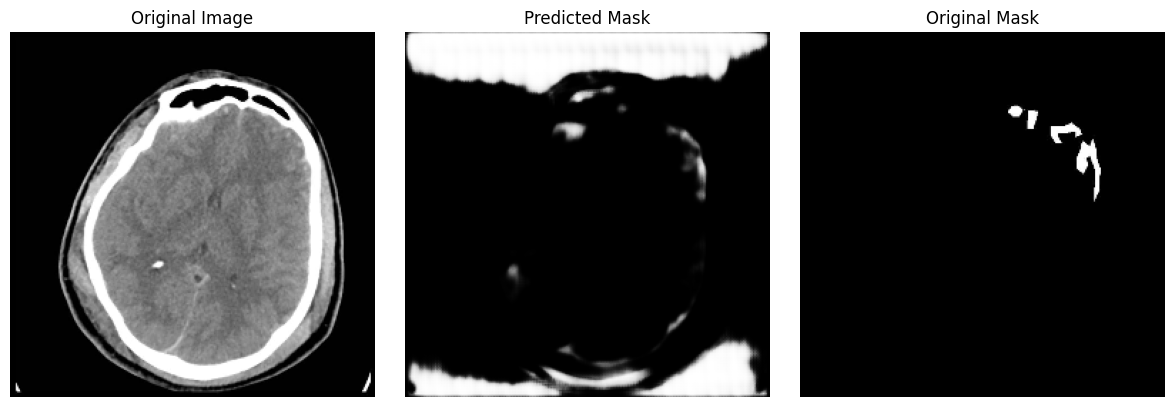

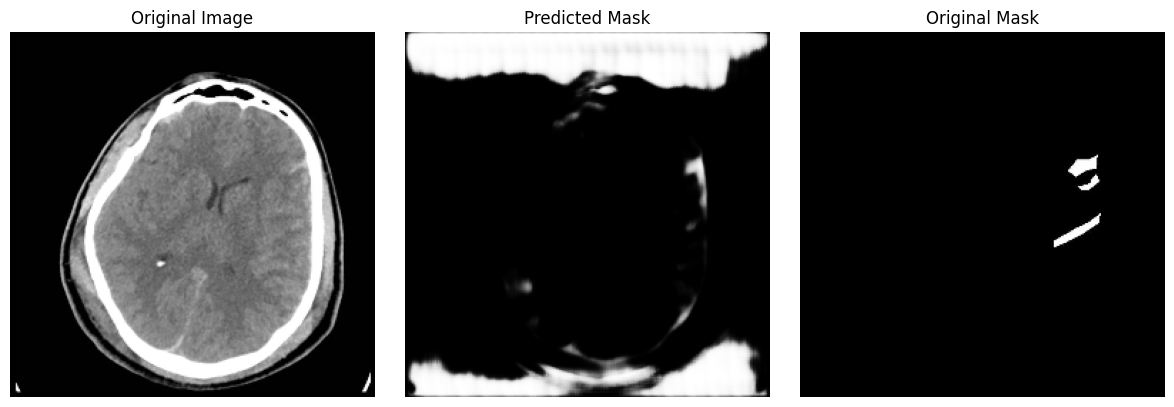

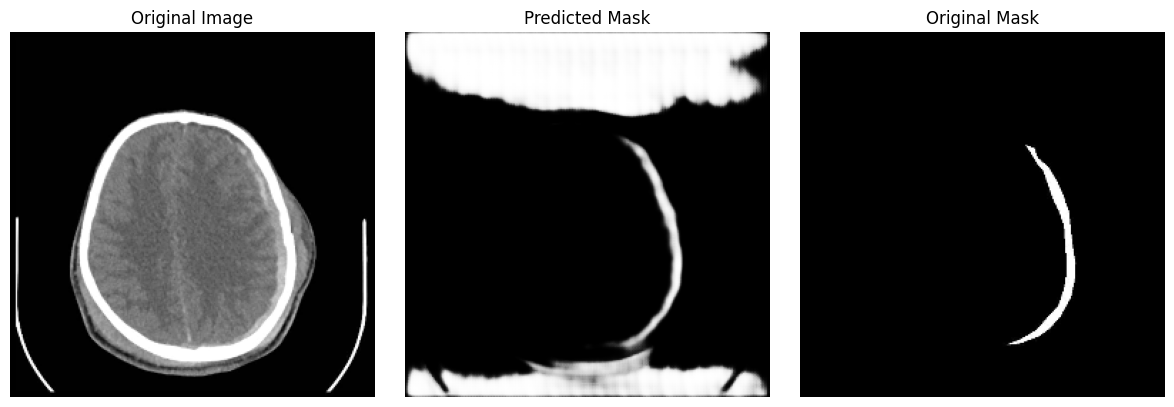

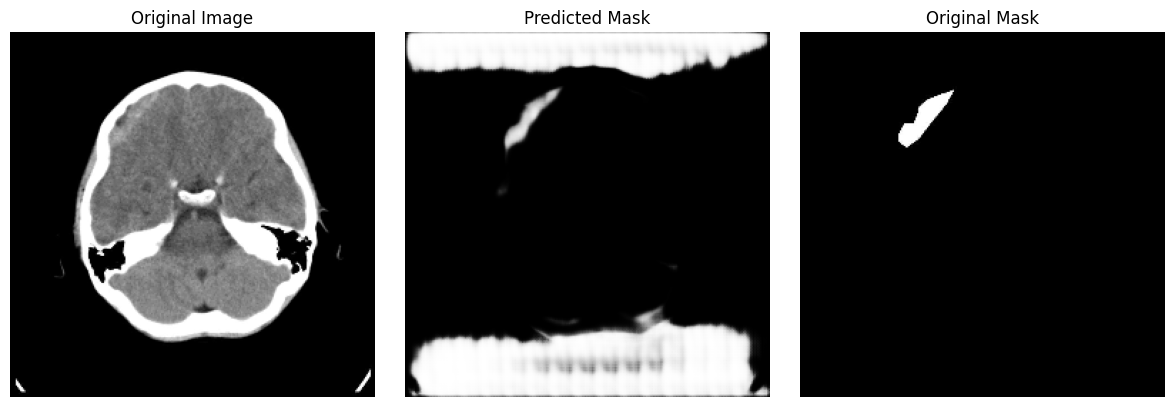

In [19]:
num_samples_to_plot = 16  # Number of samples to plot
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(test_masks[i], cmap='gray')  # Assuming you have a 'test_masks' variable
    plt.title("Original Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()